# Exporting `Drive` data as `xarray.DataArray`
## Aim
The aim is to obtain a function that takes `Drive` object as an argument and returns `xarray.DataArray` object containing the magnetization snapshots at different time steps.

## Code
```Python
def to_xarray_dataset(drive):
    """Convert Drive object to xarray.Dataset"""
    assert drive.info['driver'] == 'TimeDriver',\
                                    f"obtained '{drive.info['driver']}' insted of 'TimeDriver'"

    total_steps = drive.n
    time_steps = drive.table.data['t'].to_numpy()
    m_init = drive.m0
    array_shape = list(m_init.array.shape)
    x_points = np.fromiter(m_init.mesh.axis_points('x'), float)
    y_points = np.fromiter(m_init.mesh.axis_points('y'), float)
    z_points = np.fromiter(m_init.mesh.axis_points('z'), float)
    array_dims = [total_steps] + array_shape
    m_time_array = np.empty(tuple(array_dims))

    for step in range(total_steps):
        m_time_array[step] = drive[step].array

    m_time_dataset = xr.Dataset({'mx': (['t', 'x', 'y', 'z'], m_time_array[..., 0]),
                                 'my': (['t', 'x', 'y', 'z'], m_time_array[..., 1]),
                                 'mz': (['t', 'x', 'y', 'z'], m_time_array[..., 2])},
                                coords={'t': time_steps, 'x': x_points,
                                        'y': y_points, 'z': z_points}
                                )

    m_time_dataset.attrs = drive.info
    m_time_dataset.attrs['m0'] = m_init.array
    m_time_dataset.t.attrs['units'] = 's'
    m_time_dataset.x.attrs['units'] = 'm'
    m_time_dataset.y.attrs['units'] = 'm'
    m_time_dataset.z.attrs['units'] = 'm'
    m_time_dataset['mx'].attrs['units'] = 'A/m'
    m_time_dataset['my'].attrs['units'] = 'A/m'
    m_time_dataset['mz'].attrs['units'] = 'A/m'

    return m_time_dataset
```

Similar to the `rfft` function, the `to_xarray` collects the magnetization snapshots by looping over time steps which is finally returned as an `xarray.DataArray` object. The returned data array is assigned the same attributes as stored in `drive.info` variable.

## Use example
### Loading simulation data
>**_Note:_** This sub-section is borrowed from `Spatially Resolved FFT Ubermag.ipynb`

The simulation involves a Bloch type skyrmion state (Sky) in an FeGe disc geometry of diameter 140 nm and thickness 10 nm with an external magnetic field of strength around 188 mT perpendicular to the disc plane.

In [1]:
import micromagneticdata as md
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300  # Imporove image quality in notebook


data_path = os.path.join('.', 'data')
simulation_data = md.Data(name='SkyStable', dirname=data_path)
simulation_data.info

,drive_number,date,time,driver,t,n
0,0,2021-12-16,16:09:11,MinDriver,NaN,NaN
1,1,2021-12-16,16:46:47,TimeDriver,5.000000e-08,2000.0


`drive_number` 0 contains the stabilized skyrmion configuration.

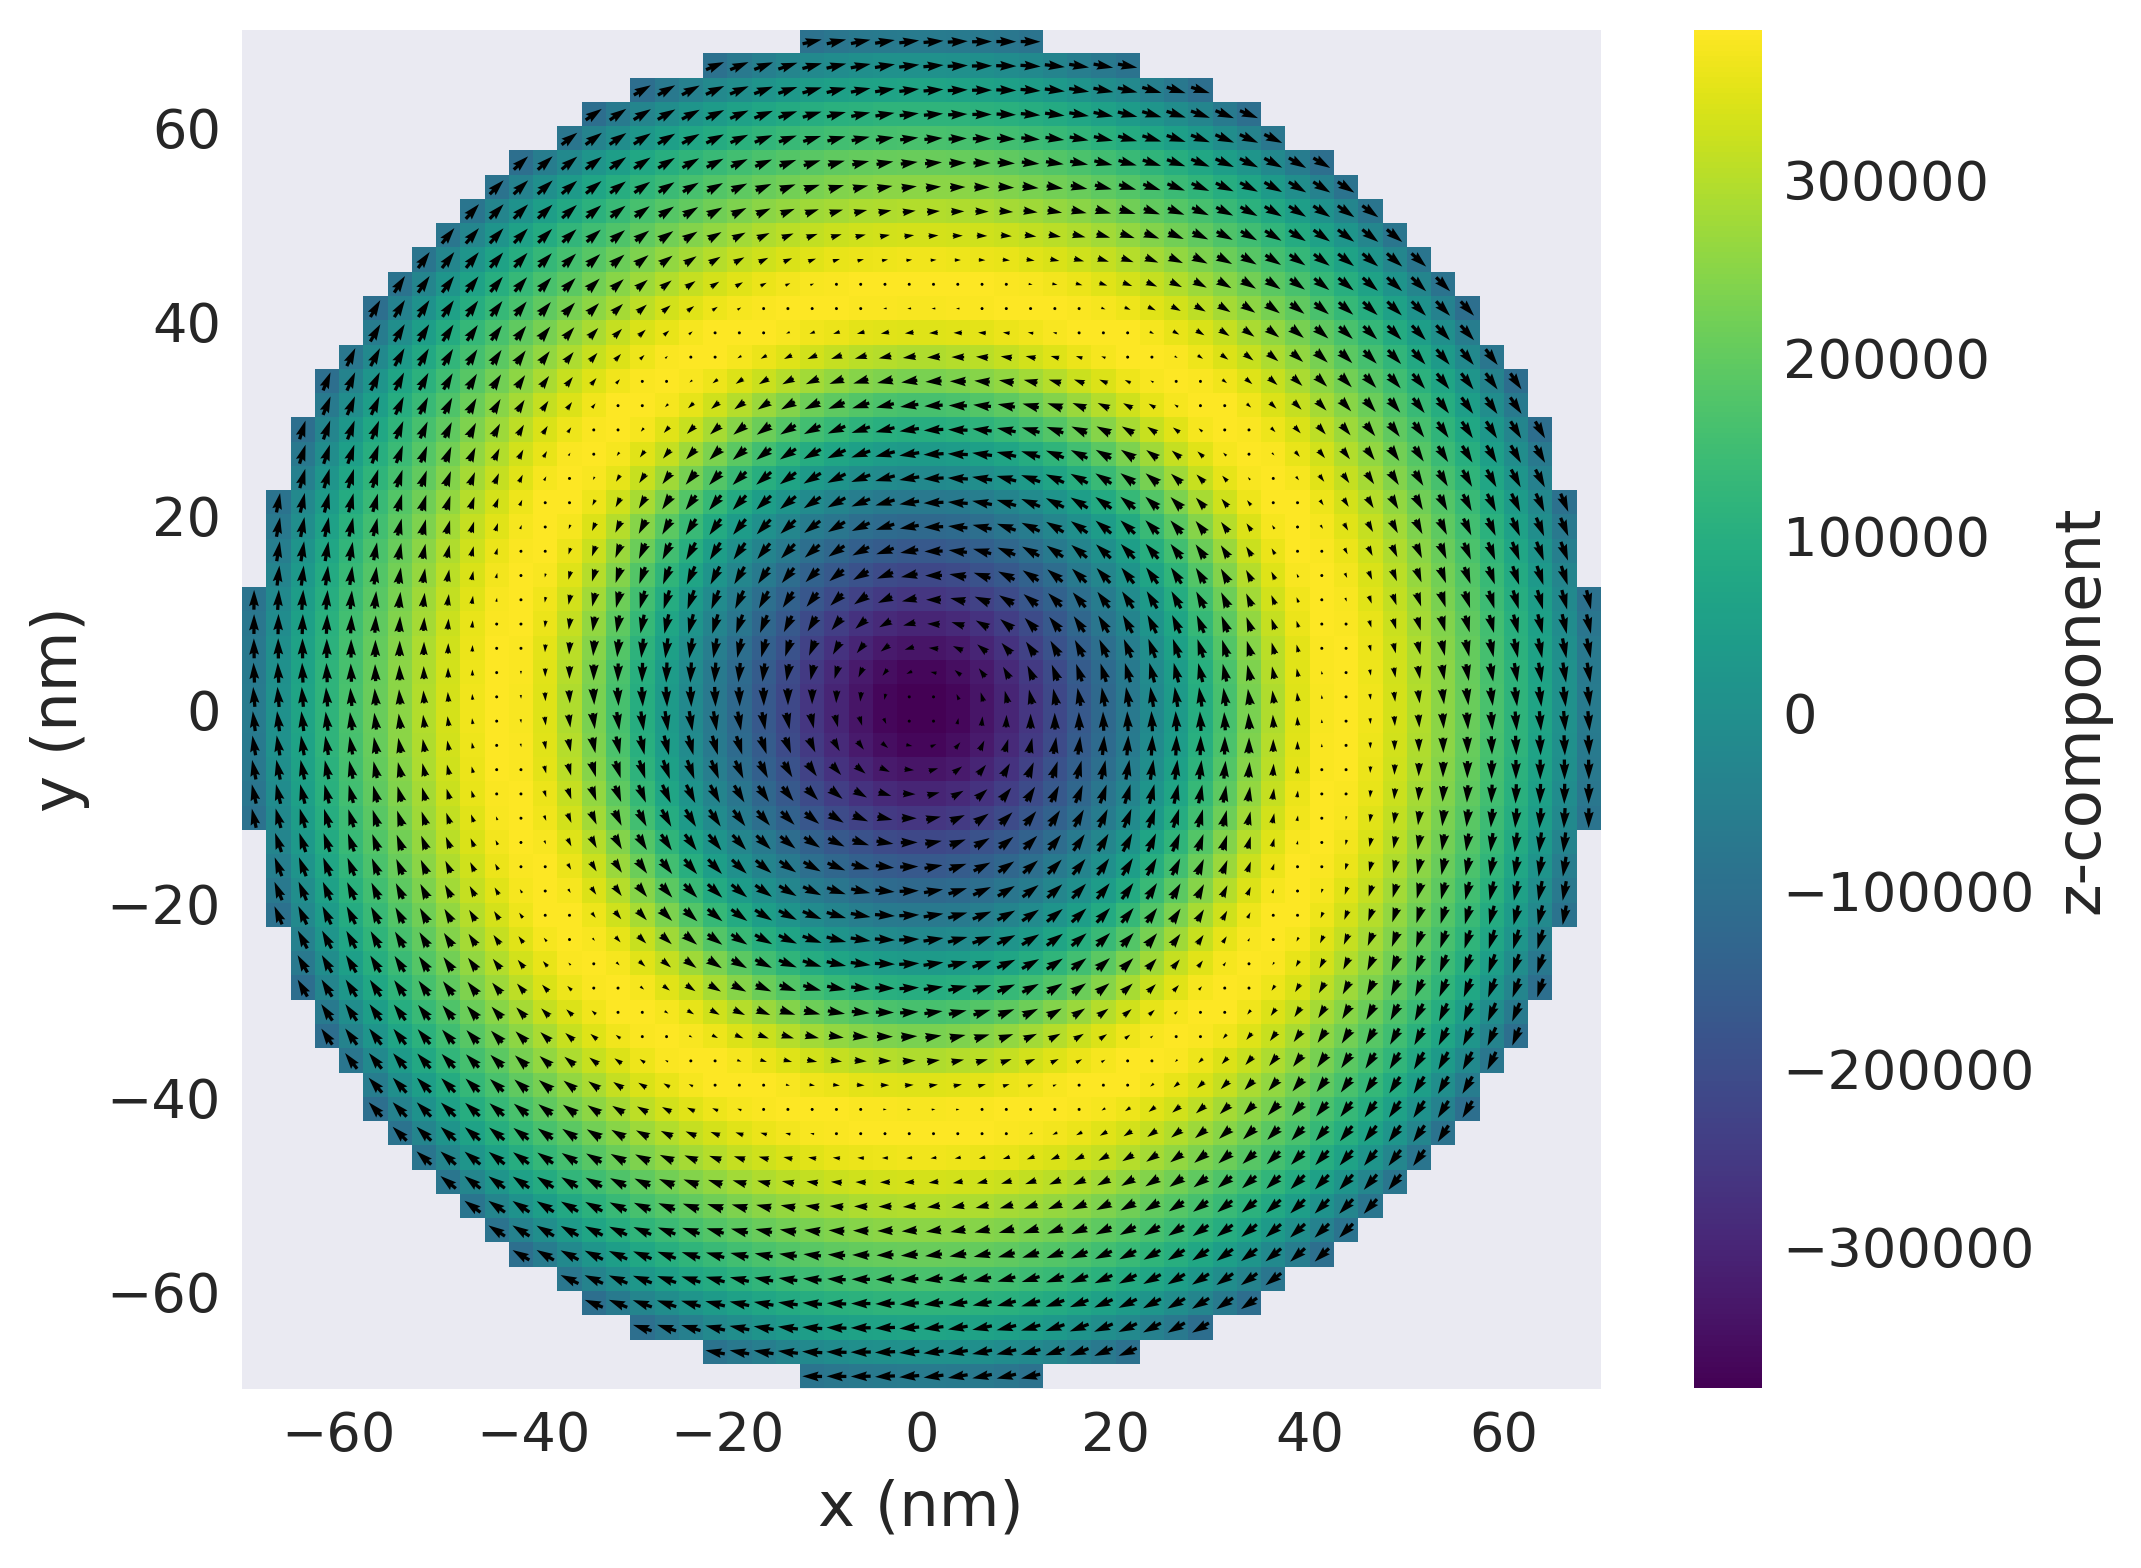

In [2]:
simulation_data[0][0].plane('z').mpl()

`drive_number` 1 contains the ringdown simulation of the above shown Sky. The state is perturbed with an in-plane sinc pulse (along x-axis) with cutoff frequency 20 GHz. 

In [3]:
simulation_data[1].info

{'drive_number': 1,
 'date': '2021-12-16',
 'time': '16:46:47',
 'driver': 'TimeDriver',
 't': 5e-08,
 'n': 2000}

In [4]:
simulation_data[1].table.data

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,E_dmi,...,By_SincPulse,Bz_SincPulse,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-1.529788e-17,679.0,0.049918,4.656087e-17,3.081513e-30,1.239073e-17,14.793751,14.793751,14.793751,-2.692919e-17,...,0.0,0.0,107.0,107.0,0.0,-1.953081e-06,3.991698e-06,0.378217,6.626105e-14,2.500000e-11
1,-1.529788e-17,1310.0,0.093907,-3.101537e-17,-6.435392e-30,1.239073e-17,14.793773,14.793773,14.793773,-2.692919e-17,...,0.0,0.0,213.0,105.0,1.0,-1.289526e-06,-1.171884e-06,0.378217,2.076040e-13,5.000000e-11
2,-1.529788e-17,1947.0,0.097331,7.895492e-17,6.706910e-30,1.239073e-17,14.793775,14.793794,14.793794,-2.692919e-17,...,0.0,0.0,320.0,106.0,2.0,-3.313830e-06,2.014107e-06,0.378217,8.496983e-14,7.500000e-11
3,-1.529788e-17,2584.0,0.271511,4.749420e-18,6.961889e-31,1.239073e-17,14.793807,14.793820,14.793820,-2.692919e-17,...,0.0,0.0,427.0,106.0,3.0,2.560229e-07,-3.937415e-06,0.378217,1.319413e-13,1.000000e-10
4,-1.529788e-17,3257.0,1.269137,4.653008e-17,2.276393e-29,1.239073e-17,14.793897,14.793897,14.793897,-2.692919e-17,...,0.0,0.0,540.0,112.0,4.0,-2.895336e-06,3.683950e-07,0.378217,1.931717e-13,1.250000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.529765e-17,3363040.0,126.525578,-3.613921e-13,-1.536920e-26,1.239073e-17,14.821567,14.830080,15.040868,-2.692898e-17,...,0.0,0.0,522666.0,262.0,1995.0,3.768153e-03,-3.630049e-03,0.378213,4.316608e-14,4.990000e-08
1996,-1.529765e-17,3364739.0,126.517524,-1.470816e-13,-5.687094e-28,1.239070e-17,14.823813,14.825230,15.040868,-2.692895e-17,...,0.0,0.0,522929.0,262.0,1996.0,5.063537e-03,-1.123383e-03,0.378212,8.482455e-14,4.992500e-08
1997,-1.529765e-17,3366438.0,123.635412,-3.847369e-13,-1.923243e-26,1.239062e-17,14.817800,14.825121,15.040868,-2.692886e-17,...,0.0,0.0,523192.0,262.0,1997.0,4.714881e-03,1.854979e-03,0.378211,5.176089e-14,4.995000e-08
1998,-1.529765e-17,3368125.0,121.944520,-1.970171e-13,-6.340469e-27,1.239061e-17,14.831841,14.833666,15.040868,-2.692884e-17,...,0.0,0.0,523455.0,262.0,1998.0,2.964051e-03,4.291334e-03,0.378209,8.208958e-14,4.997500e-08


### Using `to_xarray` function

In [5]:
from src import to_xarray_dataset, xarray_dataset_rfft


xarray_drive = to_xarray_dataset(simulation_data[1])
xarray_drive


<xarray.Dataset>
Dimensions:  (t: 2000, x: 56, y: 56, z: 4)
Coordinates:
  * t        (t) float64 2.5e-11 5e-11 7.5e-11 ... 4.995e-08 4.998e-08 5e-08
  * x        (x) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * y        (y) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * z        (z) float64 1.25e-09 3.75e-09 6.25e-09 8.75e-09
Data variables:
    mx       (t, x, y, z) float64 0.0 -0.0 0.0 -0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    my       (t, x, y, z) float64 -0.0 0.0 -0.0 0.0 0.0 ... -0.0 -0.0 0.0 -0.0
    mz       (t, x, y, z) float64 0.0 -0.0 0.0 0.0 -0.0 ... -0.0 -0.0 -0.0 0.0
Attributes:
    drive_number:  1
    date:          2021-12-16
    time:          16:46:47
    driver:        TimeDriver
    t:             5e-08
    n:             2000
    m0:            [[[[ 0.  0.  0.]\n   [ 0. -0. -0.]\n   [-0.  0.  0.]\n   [...

### Visualization with `xarray_drive`

In [6]:
import ipywidgets as widgets


@widgets.interact(step=widgets.IntSlider(min=0, max=xarray_drive.attrs['n']-1, step=1, value=0, continuous_update=False))
def plot_mag_steps(step):
    xarray_drive['mz'].isel(t=step).sel(z=8.75e-09, method='nearest').plot()


interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=1999), Output()), _d…

Magnetization snapshots (`mz` in this case) at different steps can be visualized with the help of the slider.

# Spatially resolved Fourier transform with `xarray_drive`
## Aim
The aim is to obtain a function that takes drive stored in an `xarray.DataArray` and return FFT stored in `xarray.DataArray`. This function can be either included in the examples for users or added as a convenience method for the `Drive` object.

## Code
```Python
def xarray_dataset_rfft(ds):
    """RFFT of xarray.Dataset and return transform as xarray.Dataset."""

    total_steps = ds.attrs['n']
    time_steps = ds.coords['t'].values
    x_points = ds.coords['x'].values
    y_points = ds.coords['y'].values
    z_points = ds.coords['z'].values
    time_step_size = time_steps[1] - time_steps[0]
    sampling_rate = 1.0 / time_step_size

    m_time_array = np.stack([ds['mx'].values, ds['my'].values, ds['mz'].values],
                            axis=len(ds.attrs['m0'].shape))
    dm_time_array = np.subtract(m_time_array, ds.attrs['m0'])  # broadcasting

    rfft_array = np.fft.rfft(dm_time_array, axis=0)
    frequencies = np.fft.rfftfreq(total_steps, time_step_size)

    rfft_dataset = xr.Dataset({'ft_x': (['f', 'x', 'y', 'z'], rfft_array[..., 0]),
                               'ft_y': (['f', 'x', 'y', 'z'], rfft_array[..., 1]),
                               'ft_z': (['f', 'x', 'y', 'z'], rfft_array[..., 2])},
                              coords={'f': frequencies, 'x': x_points,
                                      'y': y_points, 'z': z_points}
                              )

    rfft_dataset.attrs['max_frequency'] = f'{sampling_rate/2.0} Hz'
    rfft_dataset.attrs['frequency_resolution'] = f'{sampling_rate/total_steps} Hz'
    rfft_dataset.f.attrs['units'] = 'Hz'
    rfft_dataset.x.attrs['units'] = 'm'
    rfft_dataset.y.attrs['units'] = 'm'
    rfft_dataset.z.attrs['units'] = 'm'

    return rfft_dataset
```

> **_Note:_** This function is borrowed from `rfft` function described in `Spatially Resolved FFT Ubermag.ipynb`

## Use example

In [7]:
fft_data = xarray_dataset_rfft(xarray_drive)
fft_data


<xarray.Dataset>
Dimensions:  (f: 1001, x: 56, y: 56, z: 4)
Coordinates:
  * f        (f) float64 0.0 2e+07 4e+07 6e+07 ... 1.996e+10 1.998e+10 2e+10
  * x        (x) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * y        (y) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * z        (z) float64 1.25e-09 3.75e-09 6.25e-09 8.75e-09
Data variables:
    ft_x     (f, x, y, z) complex128 0j (-0+0j) 0j (-0+0j) 0j ... 0j 0j 0j 0j 0j
    ft_y     (f, x, y, z) complex128 (-0+0j) 0j (-0+0j) 0j 0j ... 0j 0j 0j 0j 0j
    ft_z     (f, x, y, z) complex128 0j 0j 0j 0j 0j 0j 0j ... 0j 0j 0j 0j 0j 0j
Attributes:
    max_frequency:         20000000000.0 Hz
    frequency_resolution:  20000000.0 Hz

### Power spectral density (PSD) plot
>**_Note:_** Borrowed from `Spatially Resolved FFT Ubermag.ipynb`

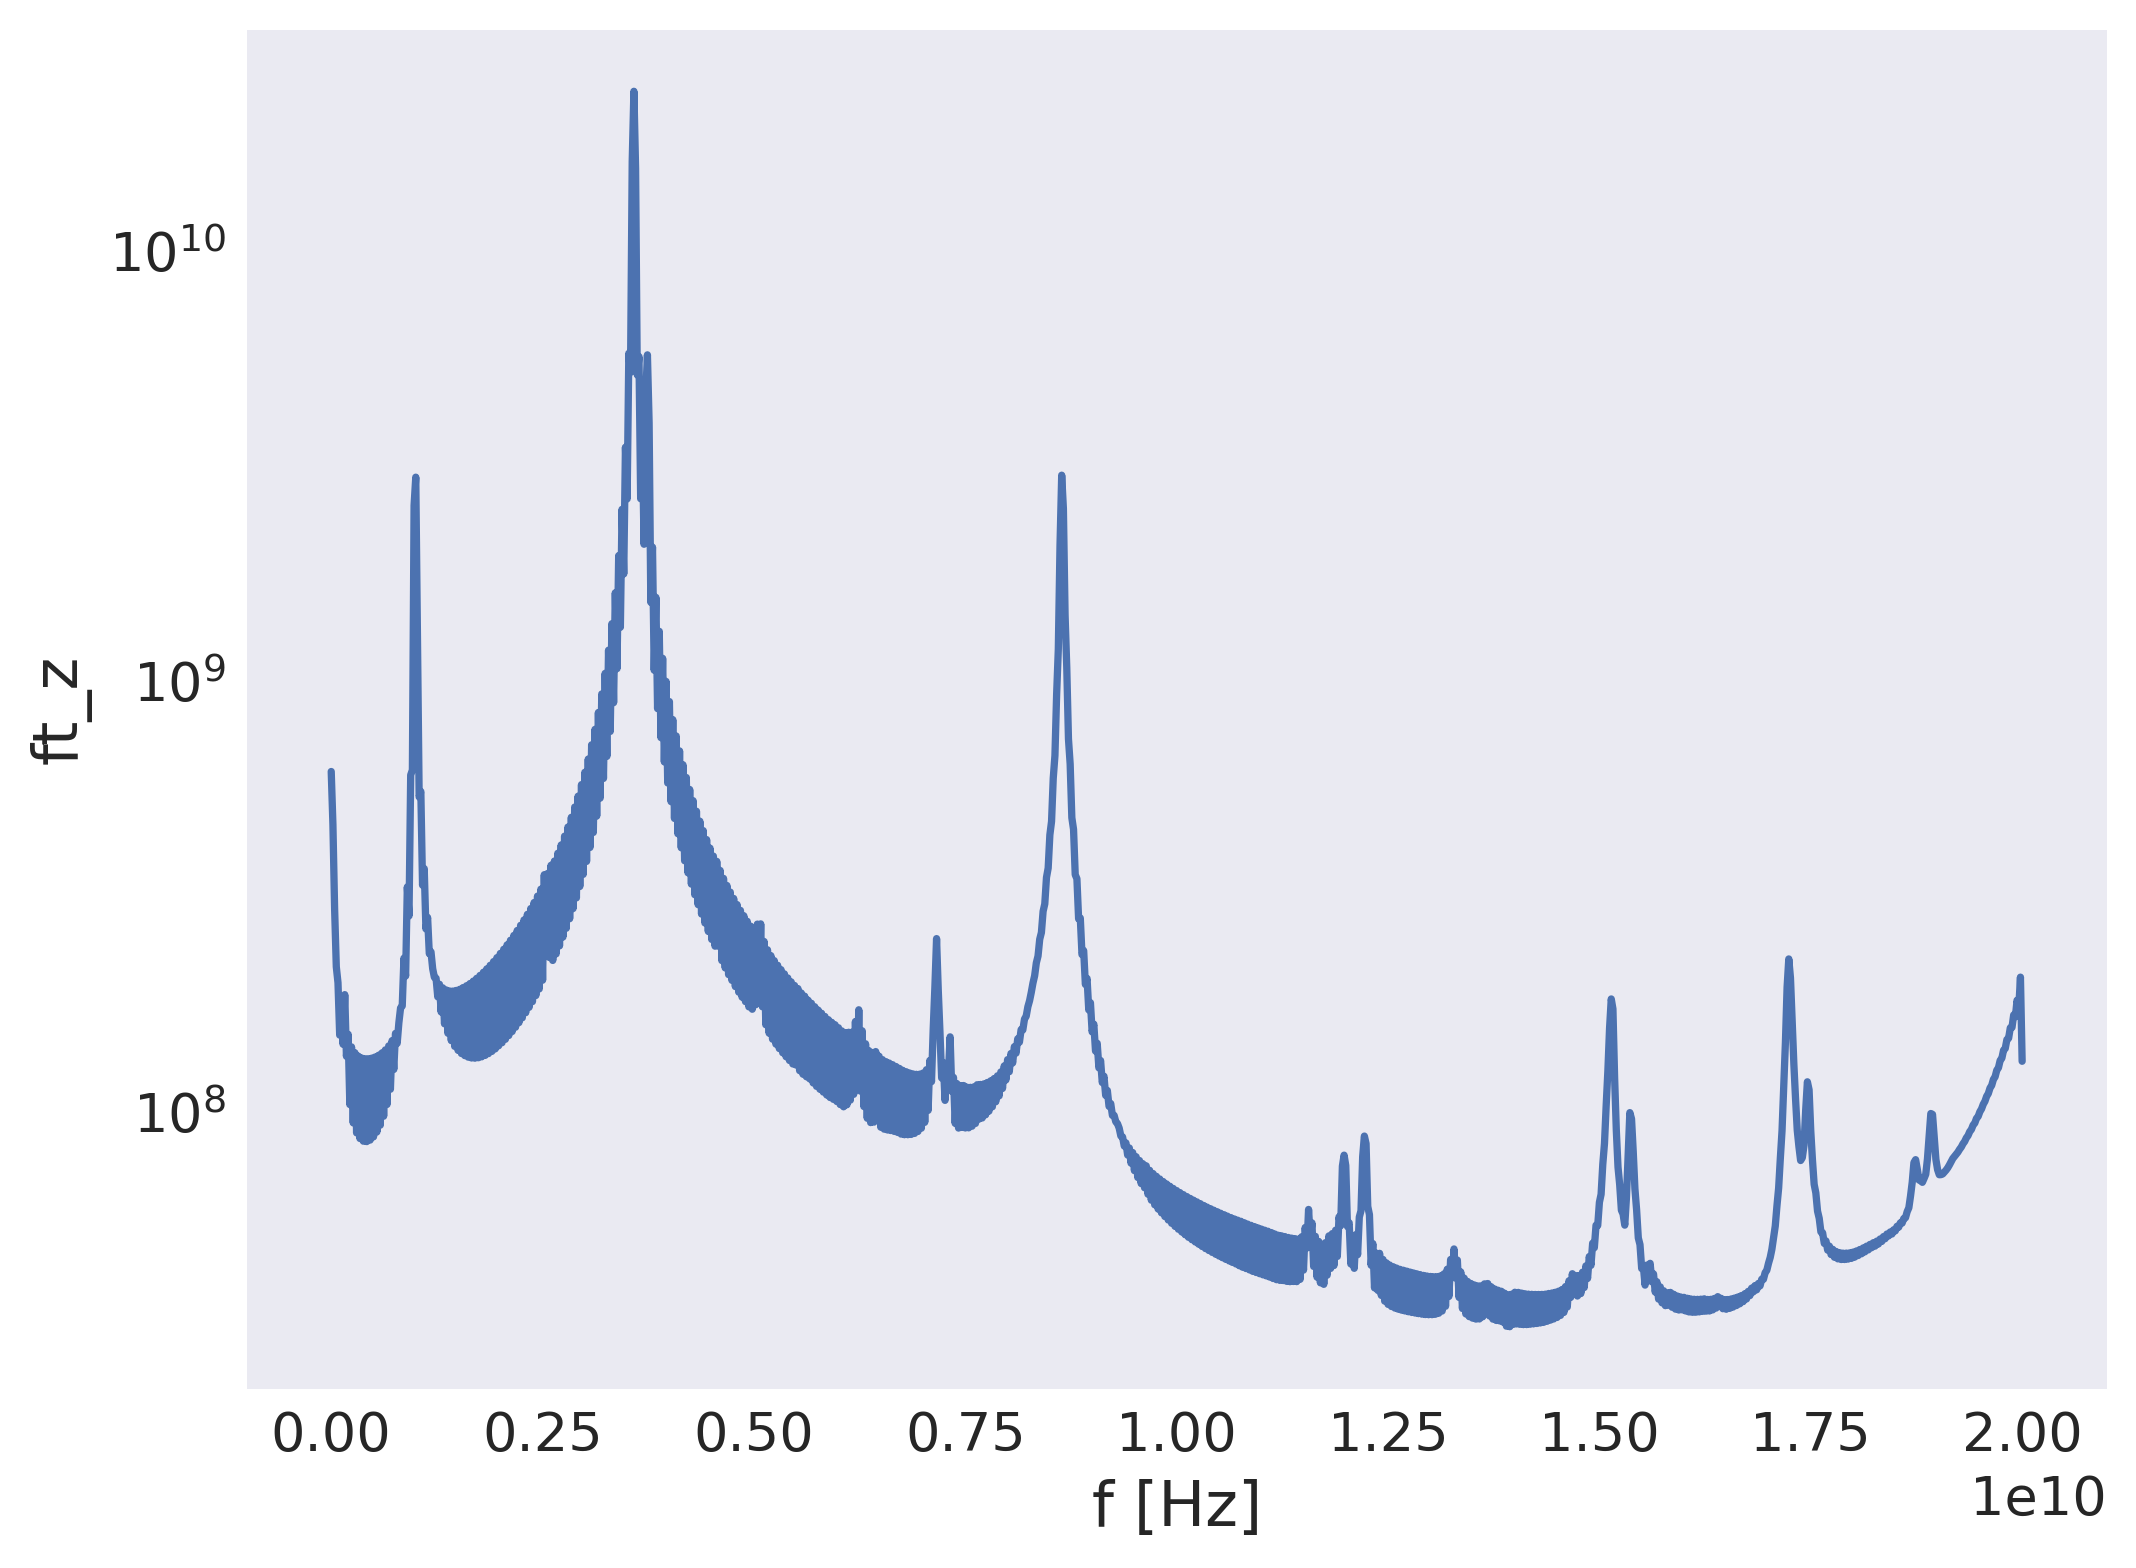

In [16]:
import numpy as np


power_fft_data = np.abs(fft_data)
power_sum_data = power_fft_data.sum(dim=['x', 'y', 'z'])
# power_sum_data = power_sum_data.drop_sel(f=0.0)  # Drop power corresponding to 0 Hz frequency
power_sum_data['ft_z'].plot.line(x='f', yscale='log')

### Power and phase of magnetization modes
>**_Note:_** Borrowed from `Spatially Resolved FFT Ubermag.ipynb`

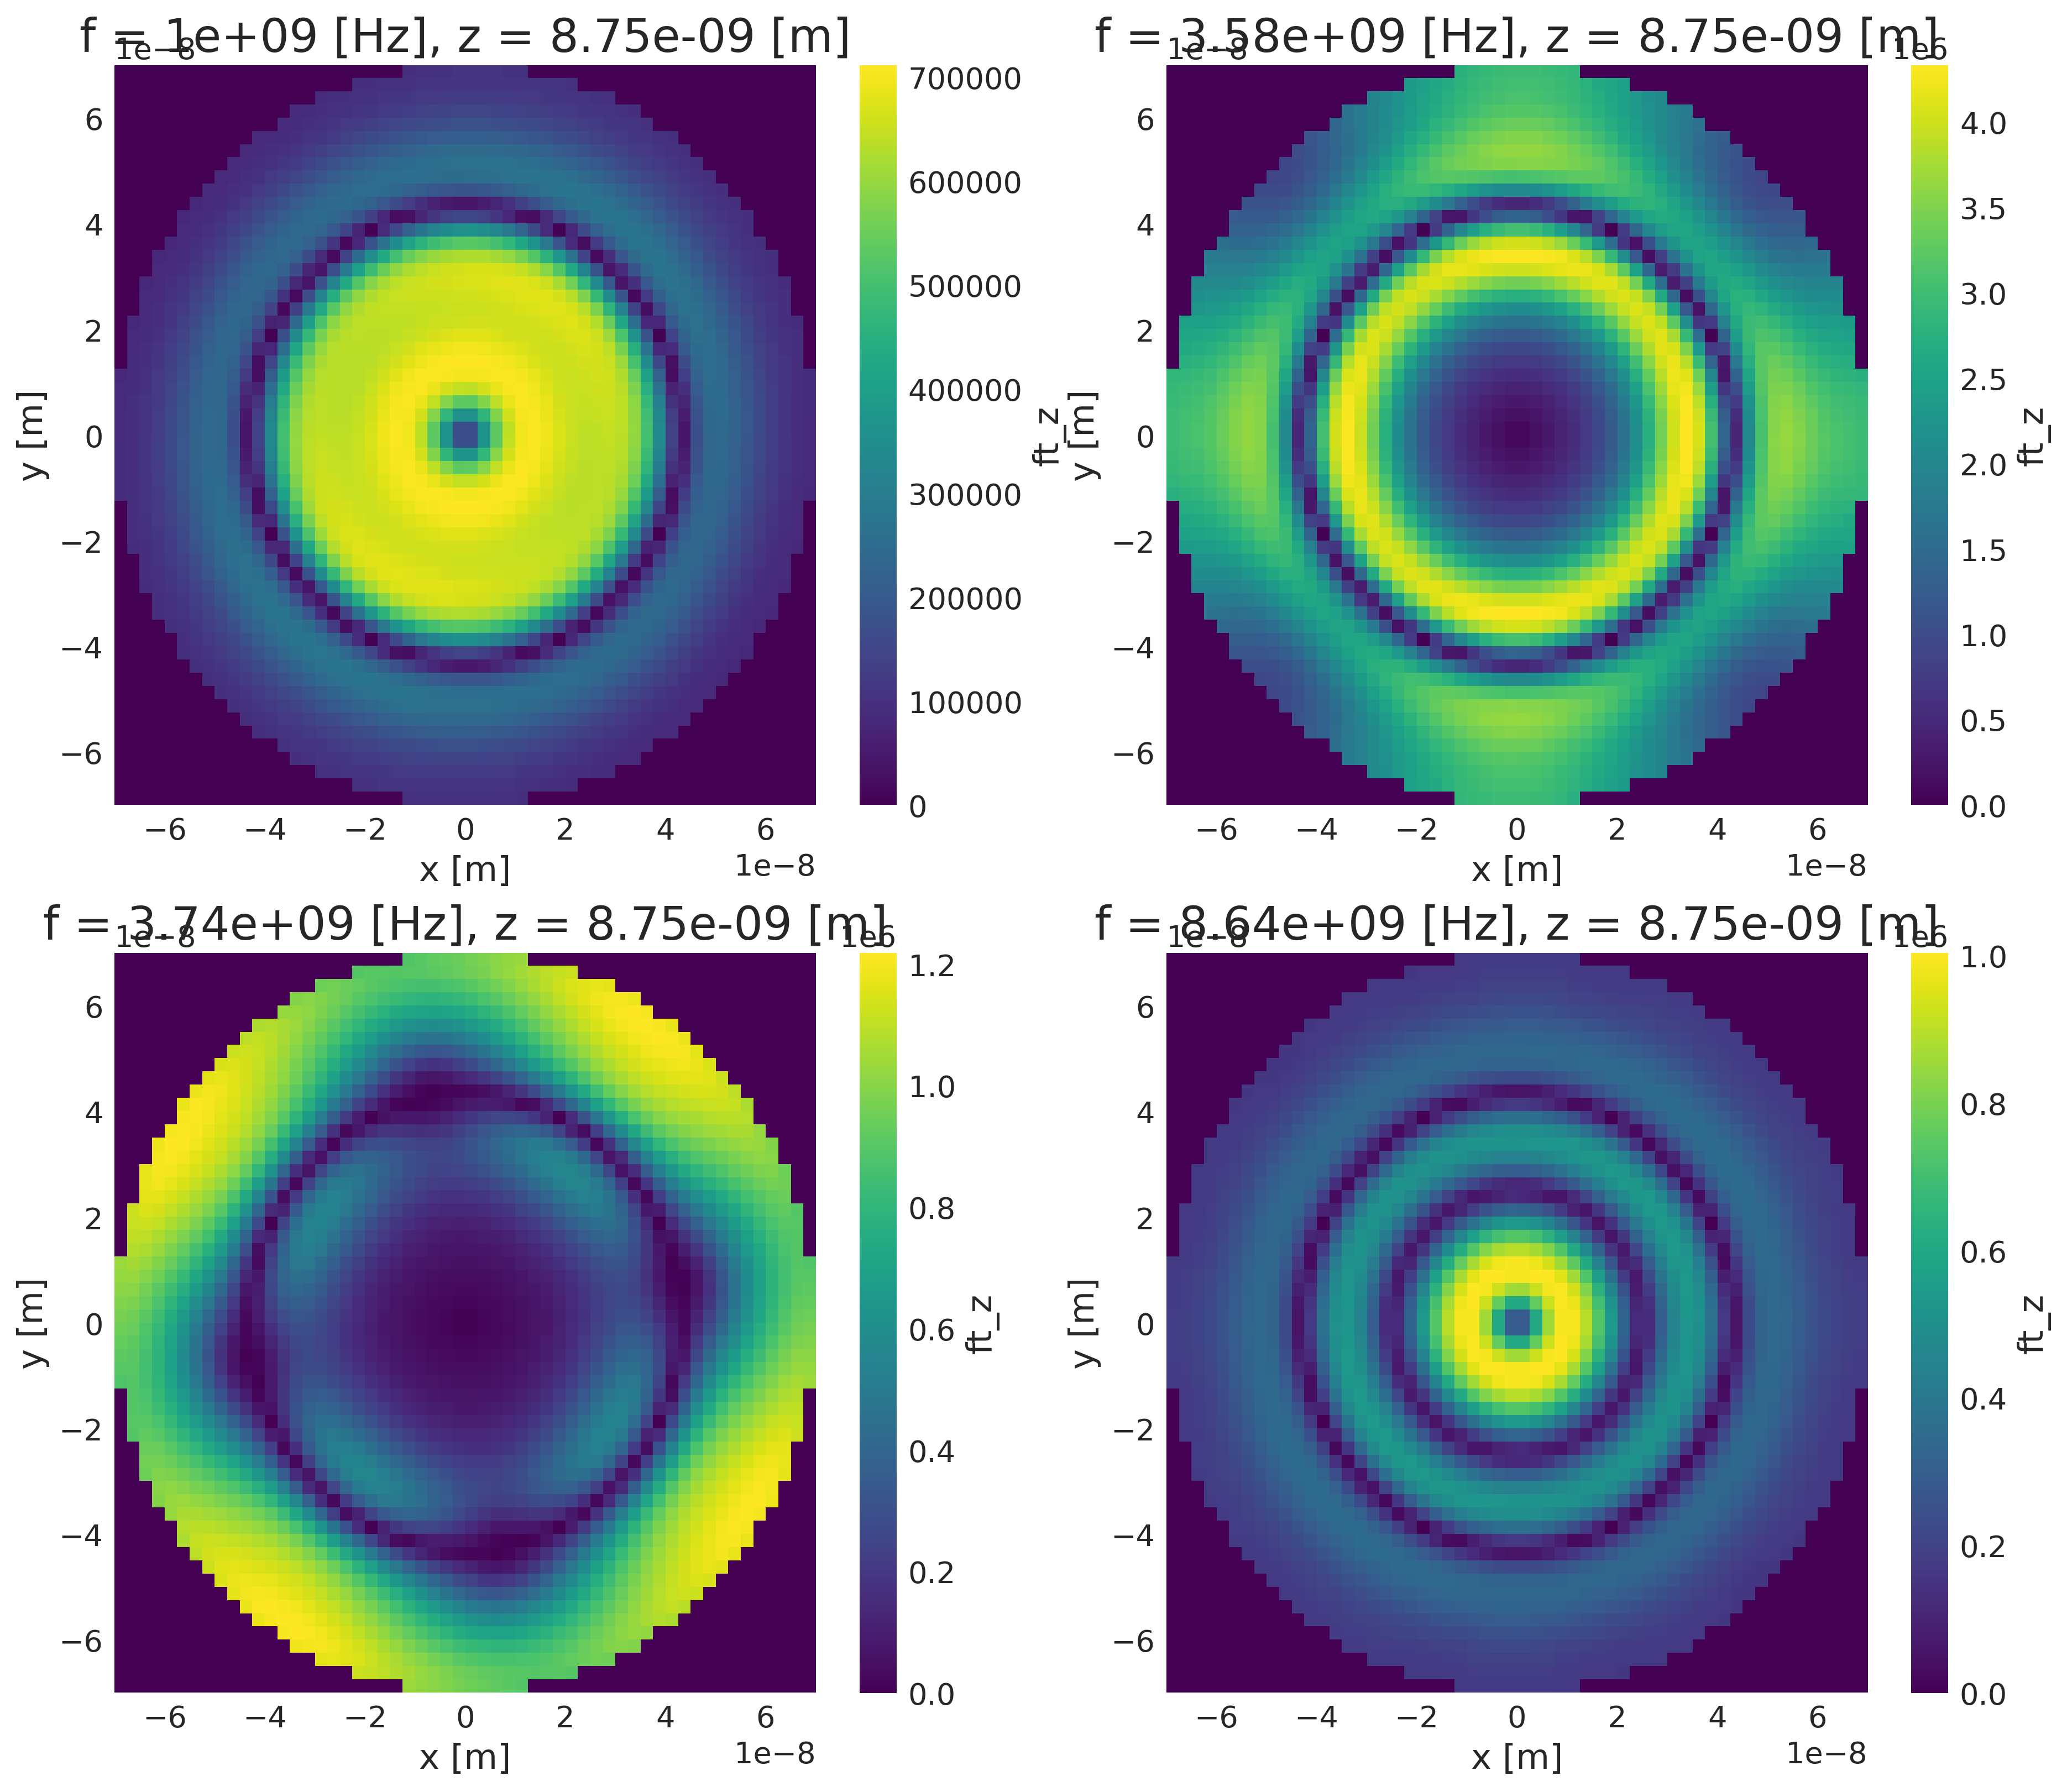

In [17]:
import matplotlib.pyplot as plt


fig_1, ax_1 = plt.subplots(2,2, figsize=(15,13))
power_fft_data['ft_z'].sel(f=1.00e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_1[0][0])
power_fft_data['ft_z'].sel(f=3.58e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_1[0][1])
power_fft_data['ft_z'].sel(f=3.74e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_1[1][0])
power_fft_data['ft_z'].sel(f=8.64e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_1[1][1])

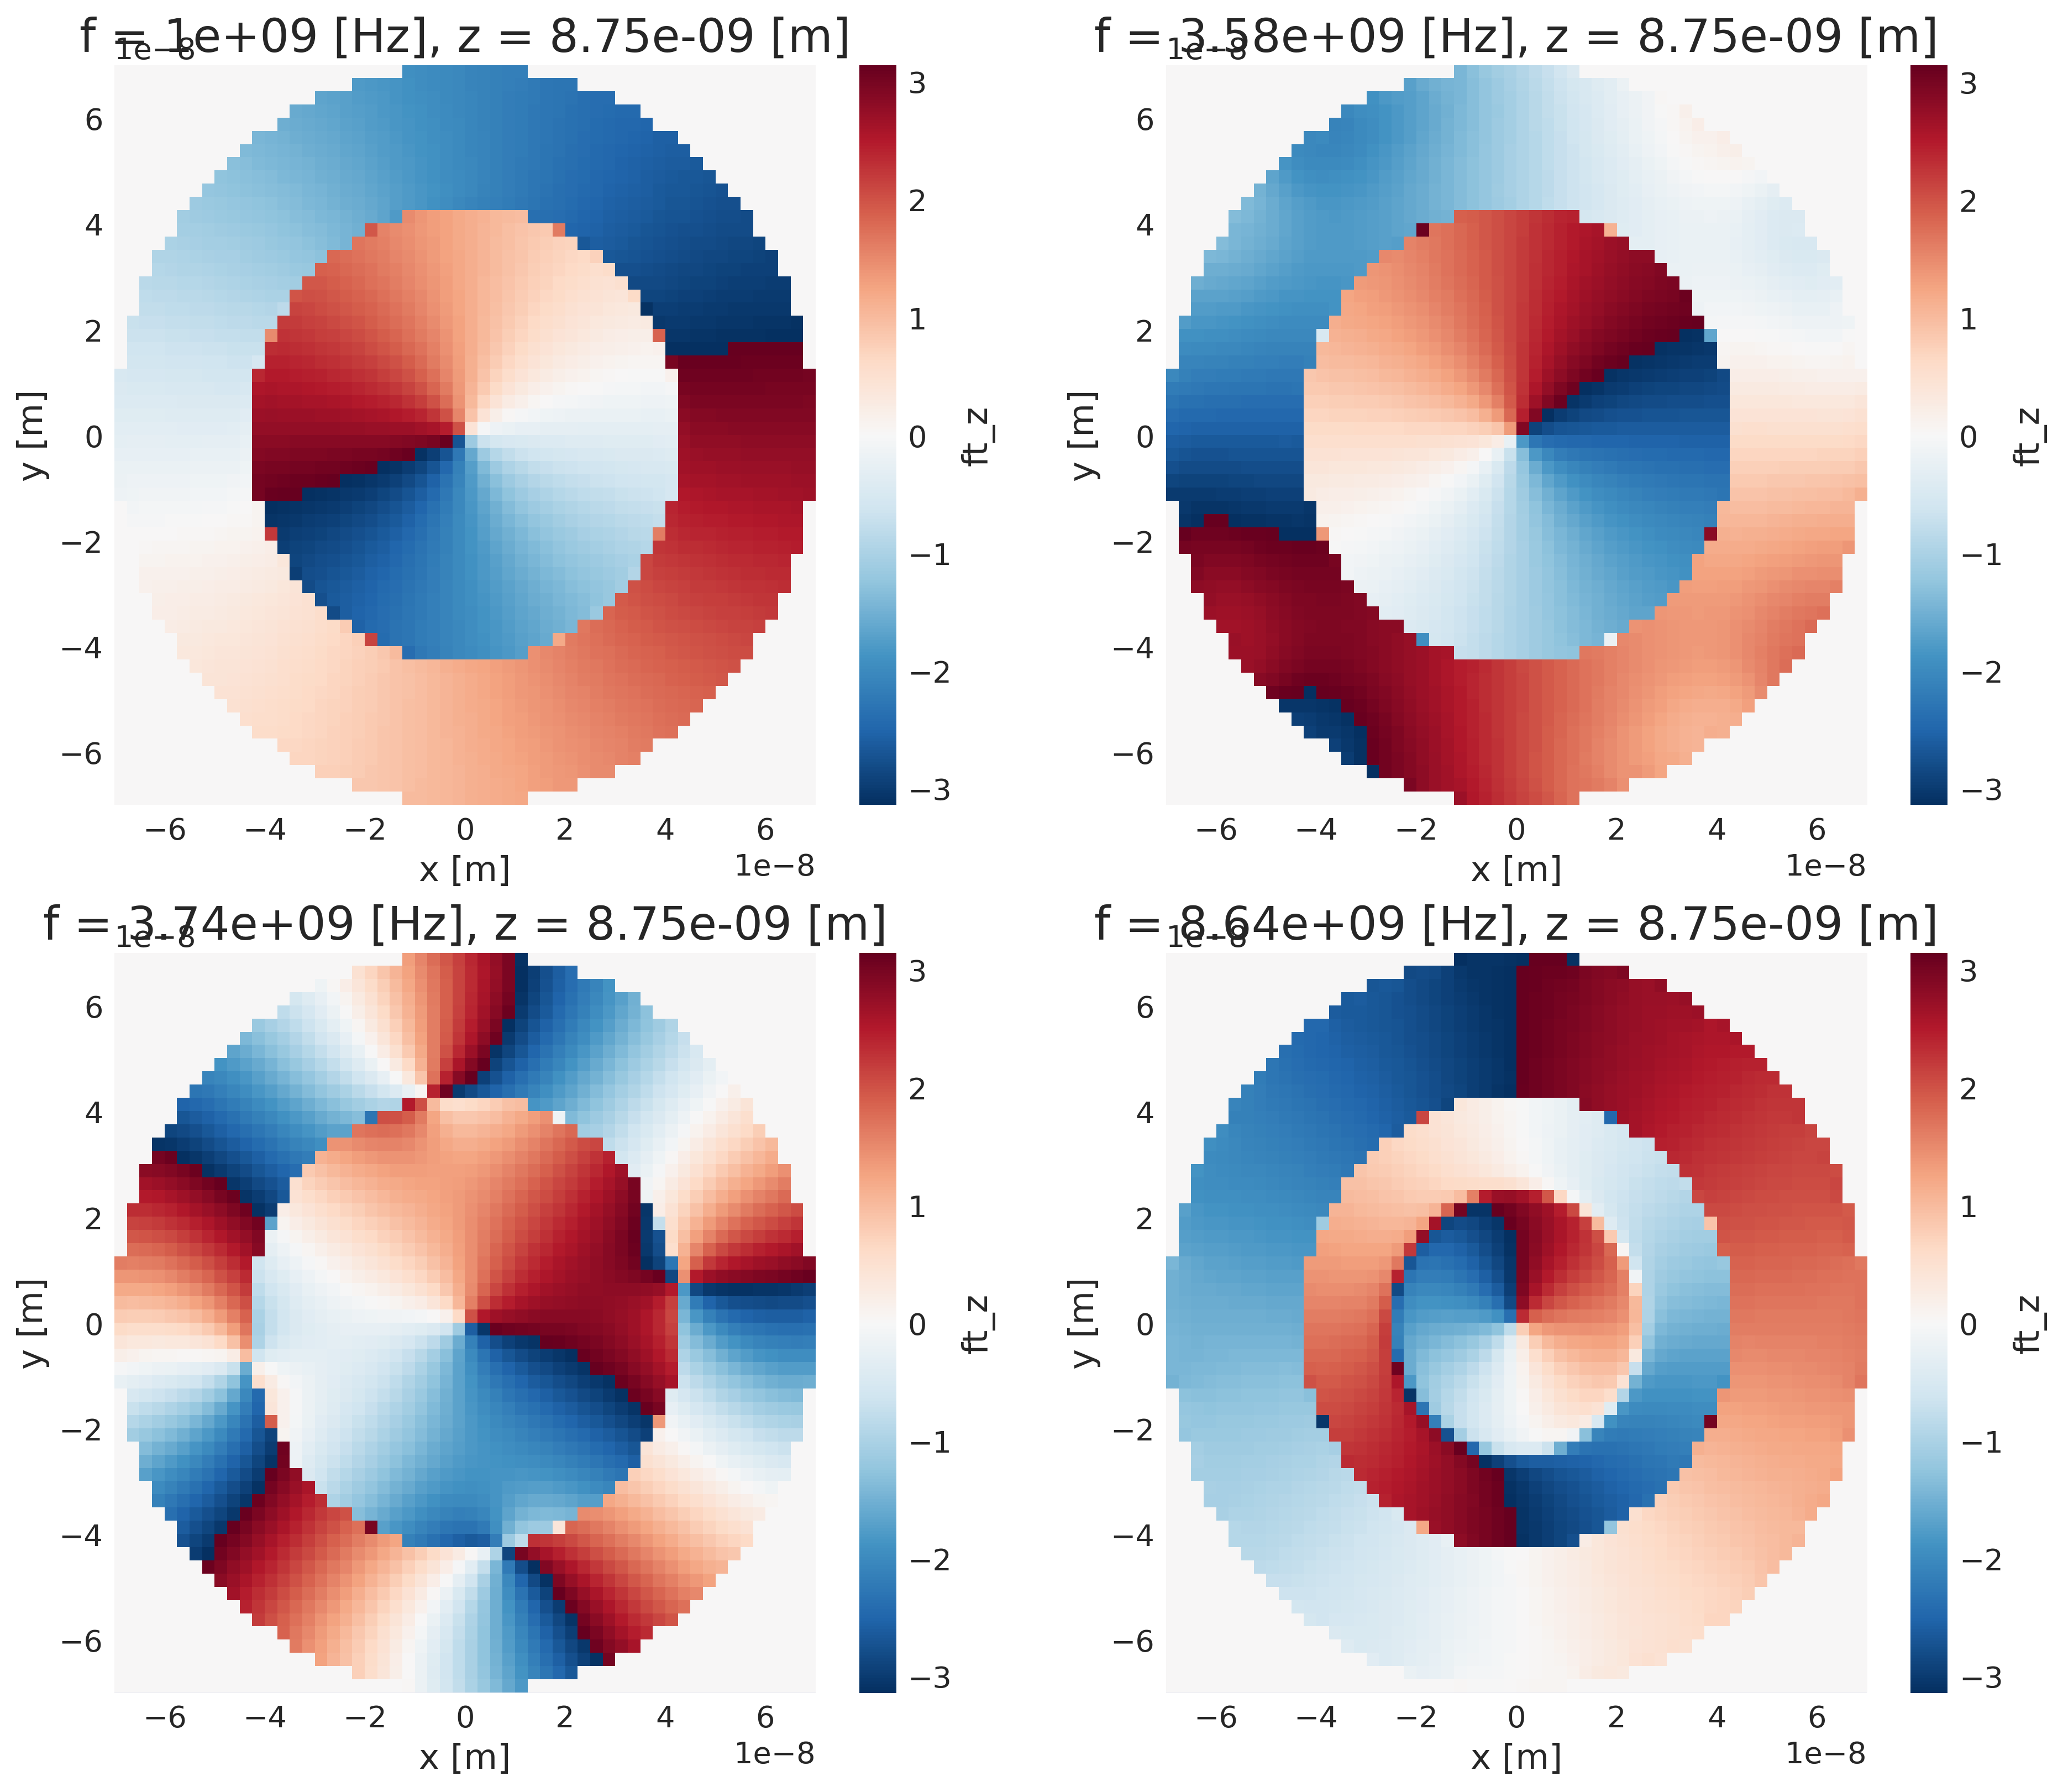

In [18]:
def ufunc_angle(z):
    zimag = np.imag(z)
    zreal = np.real(z)

    a = np.arctan2(zimag, zreal)
    
    return a

phase_fft_data = ufunc_angle(fft_data)

fig_2, ax_2 = plt.subplots(2,2, figsize=(15,13))
phase_fft_data['ft_z'].sel(f=1.00e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_2[0][0])
phase_fft_data['ft_z'].sel(f=3.58e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_2[0][1])
phase_fft_data['ft_z'].sel(f=3.74e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_2[1][0])
phase_fft_data['ft_z'].sel(f=8.64e09, z=8.75e-9).plot.imshow('x', 'y', ax=ax_2[1][1])

### Saving the data
>**_Note:_** Borrowed from `Spatially Resolved FFT Ubermag.ipynb`

In [11]:
import xarray as xr


fft_data_set = xr.Dataset({'power': power_fft_data, 'phase': phase_fft_data})
fft_data_set.attrs["long_name"] = "FFT FeGe disc 140 nm"
encoding = {'power': {'zlib': True, 'complevel': 7}, 'phase': {'zlib': True, 'complevel': 7}}  # Use encoding to compress data
fft_data_set.to_netcdf('./results/fft_disc.nc', encoding=encoding)

In [12]:
!ls ./results

fft_disc.nc


In [13]:
!du -sh ./results/fft_disc.nc

403M	./results/fft_disc.nc


To read:

In [14]:
with xr.open_dataset('./results/fft_disc.nc') as data_set_file:
    print(data_set_file, '\n\n\n')
    print(data_set_file['power'], '\n\n\n')
    print(data_set_file['phase'])

<xarray.Dataset>
Dimensions:  (f: 1001, x: 56, y: 56, z: 4, ft: 3)
Coordinates:
  * f        (f) float64 0.0 2e+07 4e+07 6e+07 ... 1.996e+10 1.998e+10 2e+10
  * x        (x) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * y        (y) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * z        (z) float64 1.25e-09 3.75e-09 6.25e-09 8.75e-09
  * ft       (ft) object 'ft_x' 'ft_y' 'ft_z'
Data variables:
    power    (f, x, y, z, ft) float64 ...
    phase    (f, x, y, z, ft) float64 ...
Attributes:
    long_name:  FFT FeGe disc 140 nm 



<xarray.DataArray 'power' (f: 1001, x: 56, y: 56, z: 4, ft: 3)>
[37669632 values with dtype=float64]
Coordinates:
  * f        (f) float64 0.0 2e+07 4e+07 6e+07 ... 1.996e+10 1.998e+10 2e+10
  * x        (x) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * y        (y) float64 -6.875e-08 -6.625e-08 ... 6.625e-08 6.875e-08
  * z        (z) float64 1.25e-09 3.75e-09 6.25e-09 8.75e-09
  * ft       (ft) object 'ft_x' 'ft_y' 'ft_z'
A